## Fig3: Alignment hierarchy

### Imports

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np
from tqdm.notebook import tqdm, trange
from convergence.plotting import plot_faverage_parcelation, add_area_labels
from convergence.operations import interpolate_alignment_series, unpack_scores
from PIL import Image

# Matplotlib arial font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

### Functions

In [2]:
def read_models_interpolated(filename, modality, n_steps=None, aggregate_models: bool = True):
    if isinstance(filename, pd.DataFrame):
        df = filename
    else:
        df = pd.read_parquet(filename)
    df = df.query(
        f"not excluded and metric=='unbiased_cka' and not excluded and modality=='{modality}' and score < 1 and score > -0.01"
    )
    df = df.rename(columns={"model_name": "model"})
    # Remove sessions
    groups = ["subject", "roi", "model", "layer"]
    df = df.groupby(groups, observed=True).aggregate({"score": "mean"}).reset_index()

    # Add depth (per model layer / max layer)
    df = df.groupby("model", observed=True).apply(
        lambda x: x.assign(depth=x.layer / x.layer.max()), include_groups=False
    )
    df = df.reset_index()
    if n_steps is None:
        n_steps = df.layer.max()

    # Drop column layer
    groups = ["subject", "roi", "model"]
    df = interpolate_alignment_series(
        df=df,
        groups=groups,
        layer_column="depth",
        score_column="score",
        interp_scores_column="scores",
    )

    if aggregate_models:
        df = df.groupby(["subject", "roi"]).scores.mean().reset_index()
        df["modality"] = modality
        df = unpack_scores(df)
        hcp = pd.read_csv(filename_hcp)
        hcp = hcp[["name", "roi", "roi_order", "area_id", "area", "area_color"]]
        df = df.merge(hcp, on="roi")

        return df
    return df


def plot_curves(df, names, fig, ax, ylim=None, legend=True, add_areas=True, ylabel="", area_palette=True, loc="upper center", ncol=2, fontsize=8.5):

    df_selected = (
        df.query("name in @names").sort_values(["area_id", "roi_order"]).reset_index().copy()
    )
    df_selected["depth"] = df_selected["layer"] / df_selected["layer"].max()
    if add_areas:  # Add areas to names
        df_selected["name"] = df_selected["name"] + " (" + df_selected["area"] + ")"

    df_selected_names = df_selected.drop_duplicates("name")

    
    names = df_selected_names.name.tolist()
    hue_order = df_selected_names.name.tolist()
    if area_palette:
        palette = df_selected_names.area_color.tolist()
    else:
        palette = None

    sns.lineplot(
        data=df_selected.query("name in @names"),
        hue="name",
        x="depth",
        y="score",
        errorbar="se",
        palette=palette,
        hue_order=hue_order,
        ax=ax,
        legend=legend,
    )
    sns.despine(ax=ax)
    # Set legend outside
    if legend:
        ax.legend(loc=loc, title="", ncol=ncol, fontsize=fontsize)

    ax.set_xlabel("Normalized Depth")
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    # Remove xticks
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=4))
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    return fig, ax

def load_peak_layers(filename, group_subjects=False, modality="vision"):
    df = pd.read_parquet(filename)
    df = df.query(f"modality=='{modality}' and not excluded and score < 1 and score > -0.05").copy()
    # Add max layer per model
    df["n_layers"] = df.groupby("model_name", observed=True).layer.transform("max")
    df = df.sort_values("score", ascending=False).drop_duplicates(subset=["subject", "roi", "session", "model_name"], keep="first")
    df["depth"] = df.layer / df.n_layers
    df = df.groupby(["roi", "subject", "model_name"], observed=True).aggregate({"score": "mean", "depth": "mean"}).reset_index()
    df = df.groupby(["roi", "subject"], observed=True).aggregate({"score": "mean", "depth": "mean"}).reset_index()
    if group_subjects:
        df = df.groupby(["roi"], observed=True).aggregate({"score": "mean", "depth": "mean"}).reset_index()
    hcp = pd.read_csv(filename_hcp)
    hcp = hcp[['roi', "name", "area", "area_id", "area_color", "roi_order", "mne_name"]]
    df = df.merge(hcp, on="roi")
    return df

def save_brain_views(
    df,
    name,
    hemispheres=["lh", "rh"],
    views=["lateral", "medial", "rostral", "caudal", "dorsal", "ventral"],
    hcp=None,
    area_ids=None,
    size=(2*800, 2*600),
    adjust=False,
    formats=["png"],
    **kwargs,
):
    for hemi in hemispheres:
        brain = plot_faverage_parcelation(df, hemisphere=hemi, size=size, **kwargs)
        if hcp is not None:
            add_area_labels(brain, hcp=hcp, area_ids=area_ids, hemispheres=[hemi])

        for view in views:
            if view == 'lateral' and adjust:
                if hemi == 'lh':
                    brain.show_view("lateral", azimuth=20, elevation=-100)
                else:
                    brain.show_view("lateral", azimuth=-20, elevation=100)
            elif view == 'medial' and adjust:
                if hemi == 'lh':
                    brain.show_view("medial",  azimuth=-20, elevation=100)
                else:
                    brain.show_view("medial",  azimuth=20, elevation=-100)
            else:
                brain.show_view(view)
            for fmt in formats:
                brain.save_image(f"{name}_{hemi}_{view}.{fmt}", mode="rgba")
        brain.close()

def plot_comparison(df, x, y, xlabel="", ylabel="", threshold_x = 0.038, threshold_y = 0.038, add_identity=False, ylim=None, xlim=None, custom={},  condition="or", default_shift_y = 0.004):
    areas = df[['area_id', "area", "area_color"]].sort_values("area_id").drop_duplicates("area_id")
    hue_order = list(areas.area.unique())
    palette = list(areas.area_color.unique())

    g = sns.jointplot(data=df, x=x, y=y, kind='scatter', marginal_kws=dict(bins=50, color='gray'), ylim=ylim, xlim=xlim)
    ax = g.ax_joint
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    ax.clear()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    sns.scatterplot(data=df, x=x, y=y, hue='area', palette=palette, hue_order=hue_order, ax=ax, legend=False)
    if add_identity:
        ax.plot([0, 1], [0, 1], ls='--', lw=0.5, color='maroon', zorder=-10)
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Add roi names as text labels
    query = ""
    if threshold_x is not None:
        query += f"{x}>{threshold_x}"

    
    if threshold_y is not None:
        if query:
            query += " " + condition + " "
        query += f"{y}>{threshold_y} "

    if query:
        df_text = df.query(query)
    for _, row in df_text.iterrows():
        shift_y = default_shift_y
        shift_x = 0
        name = row["name"]
        if name in custom:
            shift_x, shift_y = custom[name]
        ax.text(row[x] + shift_x, row[y]+shift_y, name, ha='center', va='center', fontsize=8, font='Arial', color='black')
    return g

def plot_cbar(figsize=None, cmap="viridis", vmin=0, vmax=0.2, horizontal=False, title="", percent=True, locator=0.05, rotation=-90, labelpad=20, fontsize=12, **kwargs):

    if figsize is None:
        figsize = (6, 0.4) if horizontal else (0.4, 6)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a colormap normalization
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Create a scalar mappable for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for ScalarMappable

    # Add the colorbar
    orientation = 'horizontal' if horizontal else 'vertical'
    cbar_instance = fig.colorbar(sm, cax=ax, orientation=orientation, **kwargs)
    cbar_instance.set_label(title, rotation=rotation, labelpad=labelpad, fontsize=fontsize)
    
    if percent:
        ticker = mticker.PercentFormatter(xmax=1, decimals=0)
        cbar_instance.formatter = ticker
    if locator:
        cbar_instance.locator = mticker.MultipleLocator(base=locator)

    
    return fig, ax

### Data

In [3]:
data_folder = Path("./data")
filename_hcp = data_folder / "hcp3.csv"
filename_model_joined = data_folder / "subject_model_similarities_cka_joined.parquet"
filename_model_separated = data_folder / "subject_model_similarities_cka.parquet"
filename_untrained_vision = data_folder / "untrained_vision_similarity.parquet"
filename_tokenizer = data_folder / "token_cka_similarity.parquet"
filename_untrained_language = data_folder / "untrained_language_similarity.parquet"
filename_partitions = data_folder / "nsd_partitions_model_brain.parquet"

output_folder = Path("figure_alignment_hierarchy")
output_folder.mkdir(exist_ok=True)


In [4]:
model_info = {
    "vit_base_patch14_dinov2.lvd142m_pool-cls": {'family': "DinoV2", 'size': 'Base'},
    "vit_base_patch16_224.augreg_in21k_pool-cls": {'family': "ViT AugReg", 'size': 'Base'},
    "vit_base_patch16_224.mae_pool-cls": {'family': "ViT MAE", 'size': 'Base'},
    "vit_base_patch16_clip_224.laion2b_ft_in12k_pool-cls": {'family': "ViT CLIP", 'size': 'Base'},
    "vit_base_patch16_clip_224.laion2b_pool-cls": {'family': "ViT CLIP-ft", 'size': 'Base'},
    "vit_giant_patch14_dinov2.lvd142m_pool-cls": {'family': "DinoV2", 'size': 'Giant'},
    "vit_huge_patch14_224.mae_pool-cls": {'family': "ViT MAE", 'size': 'Huge'},
    "vit_huge_patch14_clip_224.laion2b_ft_in12k_pool-cls": {'family': "ViT CLIP", 'size': 'Huge'},
    "vit_huge_patch14_clip_224.laion2b_pool-cls": {'family': "ViT CLIP-ft", 'size': 'Huge'},
    "vit_large_patch14_clip_224.laion2b_ft_in12k_pool-cls": {'family': "ViT CLIP", 'size': 'Large'},
    "vit_large_patch14_clip_224.laion2b_pool-cls": {'family': "ViT CLIP-ft", 'size': 'Large'},
    "vit_large_patch14_dinov2.lvd142m_pool-cls": {'family': "DinoV2", 'size': 'Large'},
    "vit_large_patch16_224.augreg_in21k_pool-cls": {'family': "ViT AugReg", 'size': 'Large'},
    "vit_large_patch16_224.mae_pool-cls": {'family': "ViT MAE", 'size': 'Large'},
    "vit_small_patch14_dinov2.lvd142m_pool-cls": {'family': "DinoV2", 'size': 'Small'},
    "vit_small_patch16_224.augreg_in21k_pool-cls": {'family': "ViT AugReg", 'size': 'Small'},
    "vit_tiny_patch16_224.augreg_in21k_pool-cls": {'family': "ViT AugReg", 'size': 'Tiny'},
    "huggyllama_llama-13b_pool-avg_prompt-coco": {'family': "Llama", 'size': '13B'},
    "huggyllama_llama-7b_pool-avg_prompt-coco": {'family': "Llama", 'size': '7B'},
    "meta-llama_Llama-3.1-8B_pool-avg_prompt-coco": {'family': "Llama 3.1", 'size': '3.1-8B'},
    "meta-llama_Meta-Llama-3-8B_pool-avg_prompt-coco": {'family': "Llama 3", 'size': '3-8B'},
    "openlm-research_open_llama_13b_pool-avg_prompt-coco": {'family': "Openlm Llama", 'size': '13B'},
    "openlm-research_open_llama_3b_pool-avg_prompt-coco": {'family': "Openlm Llama", 'size': '3B'},
    "openlm-research_open_llama_7b_pool-avg_prompt-coco": {'family': "Openlm Llama", 'size': '7B'},
}

### Subfig: Model alignment curves

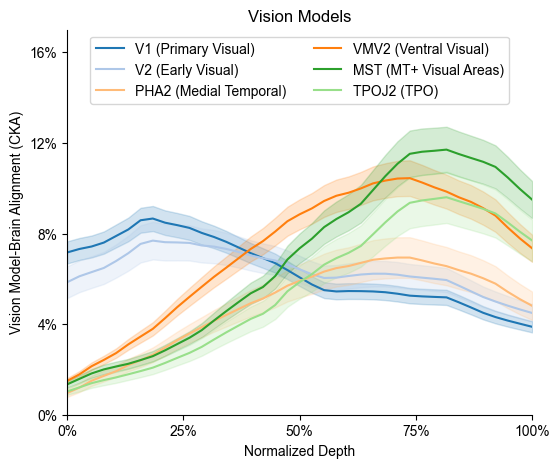

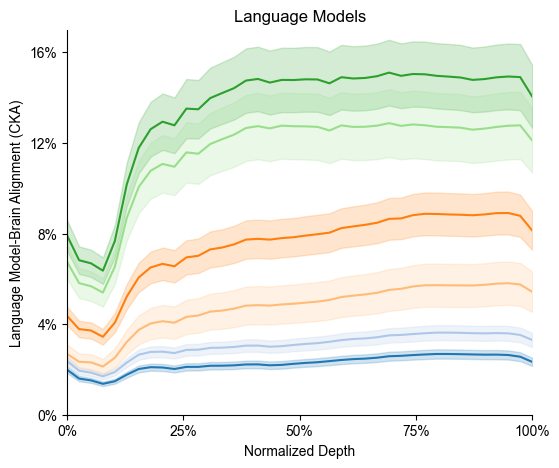

In [11]:
df_vision = read_models_interpolated(filename_model_joined, modality='vision')
df_language = read_models_interpolated(filename_model_joined, modality='language')

df_vision.area = df_vision.area.replace({"Early Visual (V2-4)": "Early Visual"})
df_language.area = df_language.area.replace({"Early Visual (V2-4)": "Early Visual"})

names = ["V1", "V2",  "PHA2", "VMV2", "MST", "TPOJ2"]#,  "DVT"]
ylim = (0, 0.181)


for legend in [True]:
    # Reduce padding
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 5), sharey=True, gridspec_kw={'wspace': 0.1})
    fig2, ax2 = plt.subplots(1, 1, figsize=(6, 5), sharey=True, gridspec_kw={'wspace': 0.1})
    plot_curves(df_vision, names, fig=fig, ax=ax1, ylim=ylim, legend=legend, fontsize=9)
    # Sort legend labels [0, 1, 3, 2, 4, 5]
    handles, labels = ax1.get_legend_handles_labels()
    handles = [handles[0], handles[1], handles[3], handles[2], handles[4], handles[5]]
    labels = [labels[0], labels[1], labels[3], labels[2], labels[4], labels[5]]
    ax1.legend(handles, labels, loc='upper center', ncol=2)


    plot_curves(df_language, names, fig=fig, ax=ax2, ylim=ylim, legend=False)
    ax1.set_ylabel("Vision Model-Brain Alignment (CKA)")
    ax1.set_title("Vision Models")
    ax2.set_ylabel("Language Model-Brain Alignment (CKA)")
    ax2.set_title("Language Models")
    ax1.set_ylim(0, 0.17)
    ax2.set_ylim(0, 0.17)
    ax1.yaxis.set_major_locator(mticker.MultipleLocator(0.04))
    ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.04))

    folder = output_folder / "model_curves"
    folder.mkdir(exist_ok=True)
    suffix = "_legend" if legend else ""
    # fig.savefig(folder / f"model_curves_vision_{suffix}.svg", bbox_inches='tight',transparent=True)
    # fig.savefig(folder / f"model_curves_vision_{suffix}.pdf", bbox_inches='tight',transparent=True)
    # fig2.savefig(folder / f"model_curves_language_{suffix}.svg", bbox_inches='tight',transparent=True)
    # fig2.savefig(folder / f"model_curves_language_{suffix}.pdf", bbox_inches='tight',transparent=True)

# # Copy ax1 legend into a new figure
# fig_legend = plt.figure(figsize=(6, 1))
# ax = fig_legend.add_subplot(111)
# ax.axis('off')
# ax.legend(*ax1.get_legend_handles_labels(), loc='center', ncol=2, fontsize=8)
# fig_legend.savefig(folder / "model_curves_legend.svg", bbox_inches='tight', transparent=True)
# fig_legend.savefig(folder / "model_curves_legend.pdf", bbox_inches='tight', transparent=True)
# #plt.close('all')

Text(0.5, 1.0, 'Language')

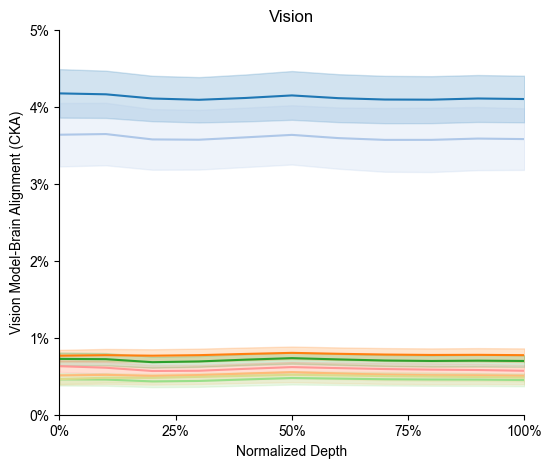

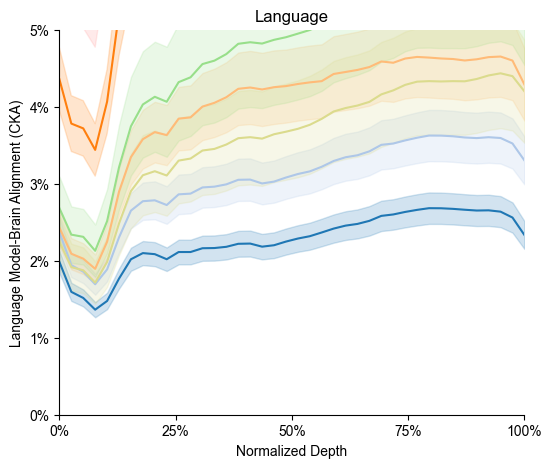

In [9]:
# Reduce padding
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True, gridspec_kw={'wspace': 0.1})
plot_curves(df_vision, names, fig=fig, ax=ax, ylim=ylim, legend=False, fontsize=9)
ax.set_ylabel("Vision Model-Brain Alignment (CKA)")
ax.set_title("Vision")
fig.savefig(folder / f"model_curves_vision.svg", bbox_inches='tight')
fig.savefig(folder / f"model_curves_vision.pdf", bbox_inches='tight')
#plt.close()

fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True, gridspec_kw={'wspace': 0.1})
plot_curves(df_language, names, fig=fig, ax=ax, ylim=ylim, legend=False, fontsize=9)
ax.set_ylabel("Language Model-Brain Alignment (CKA)")
ax.set_title("Language")
#fig.savefig(folder / f"model_curves_language.svg", bbox_inches='tight')
#fig.savefig(folder / f"model_curves_language.pdf", bbox_inches='tight')
#plt.close()

### Vision curves for ALL areas

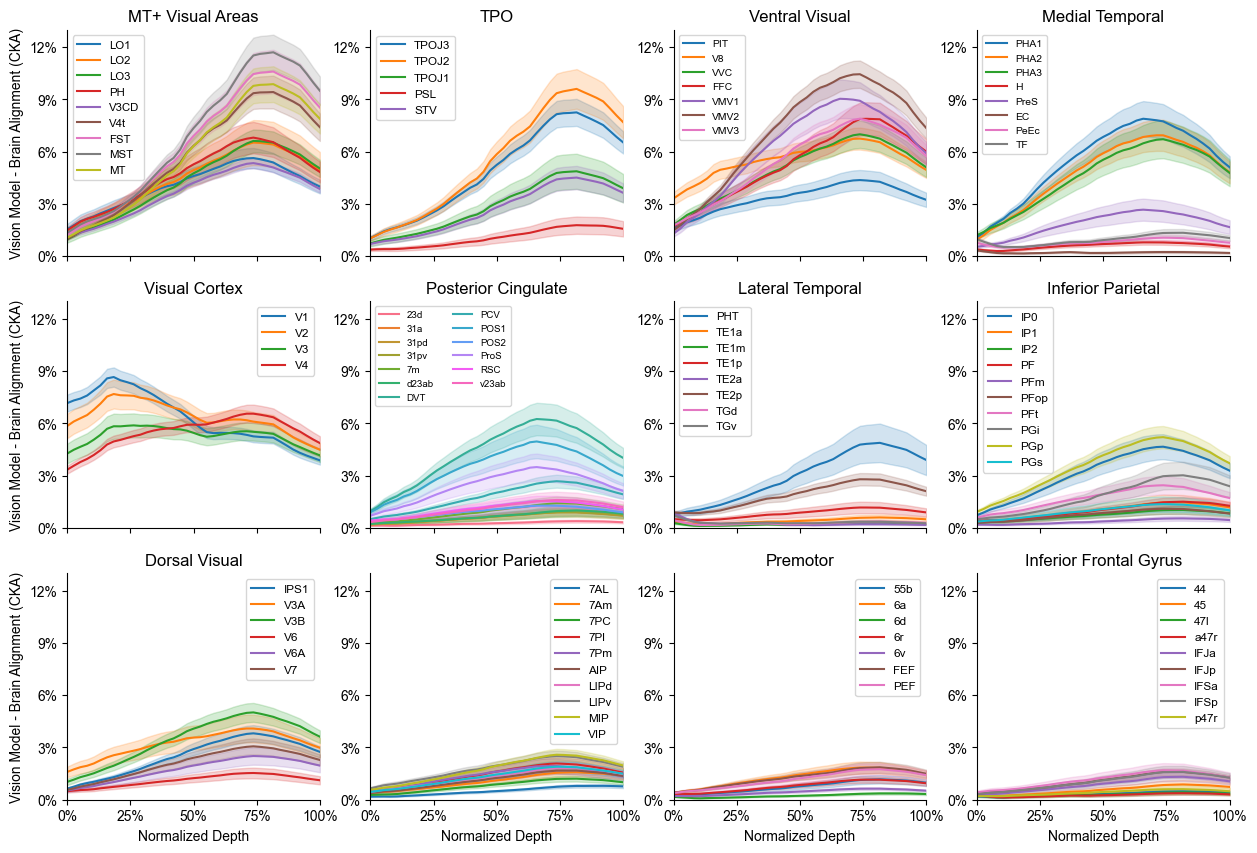

In [9]:
areas = df_vision.sort_values("score", ascending=False).drop_duplicates("area_id").area.tolist()

fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=False)
axes = iter(axes.flatten())

custom = {"TPO": {'ncol': 1},
          "Lateral Temporal": {'ncol': 1, "fontsize": 8.2},
          "MT+ Visual Areas": {'ncol': 1, "fontsize": 8.2},
          "Ventral Visual": {'ncol': 1, "fontsize": 7.5},
          "Medial Temporal": {'ncol': 1, "fontsize": 7.5, "ylim": (0, 0.1)},
          "Posterior Cingulate": {'ncol': 2, "ylim": (0, 0.1), "fontsize": 7, "loc": "upper left"},
          }

for i, area in enumerate(areas[:13]):
    if "Primary" in area: continue
    if "Early" in area:
        area = "Visual Cortex"
        names = ["V1", "V2", "V3", "V4"]
    else:
        df_vision_area = df_vision.query(f"area == '{area}'")
        names = df_vision_area.sort_values("roi_order").drop_duplicates("name").name.tolist()
    ax = next(axes)

    ncol = 1
    fontsize = 8.5
    ylim = None
    loc = "best"
    if area in custom:
        ncol = custom[area].get("ncol", ncol)
        fontsize = custom[area].get("fontsize", fontsize)    
        ylim = custom[area].get("ylim", None)
        loc = custom[area].get("loc", "best")
    
    plot_curves(df_vision, names, fig=fig, ax=ax, legend=True, add_areas=False, area_palette=False, loc=loc, ncol=ncol, fontsize=fontsize)
    ax.set_title(area)
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim(0, None)
    if i > 8:
        # Each 0.01
        ax.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
    elif i>6:
        ax.yaxis.set_major_locator(mticker.MultipleLocator(0.02))
    if i in [0, 4, 9]:
        ax.set_ylabel("Vision Model - Brain Alignment (CKA)")

    ax.set_ylim(0, 0.13)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.03))
fig.savefig(folder / "model_curves_vision_top_12.svg", bbox_inches='tight')
fig.savefig(folder / "model_curves_vision_top_12.pdf", bbox_inches='tight')

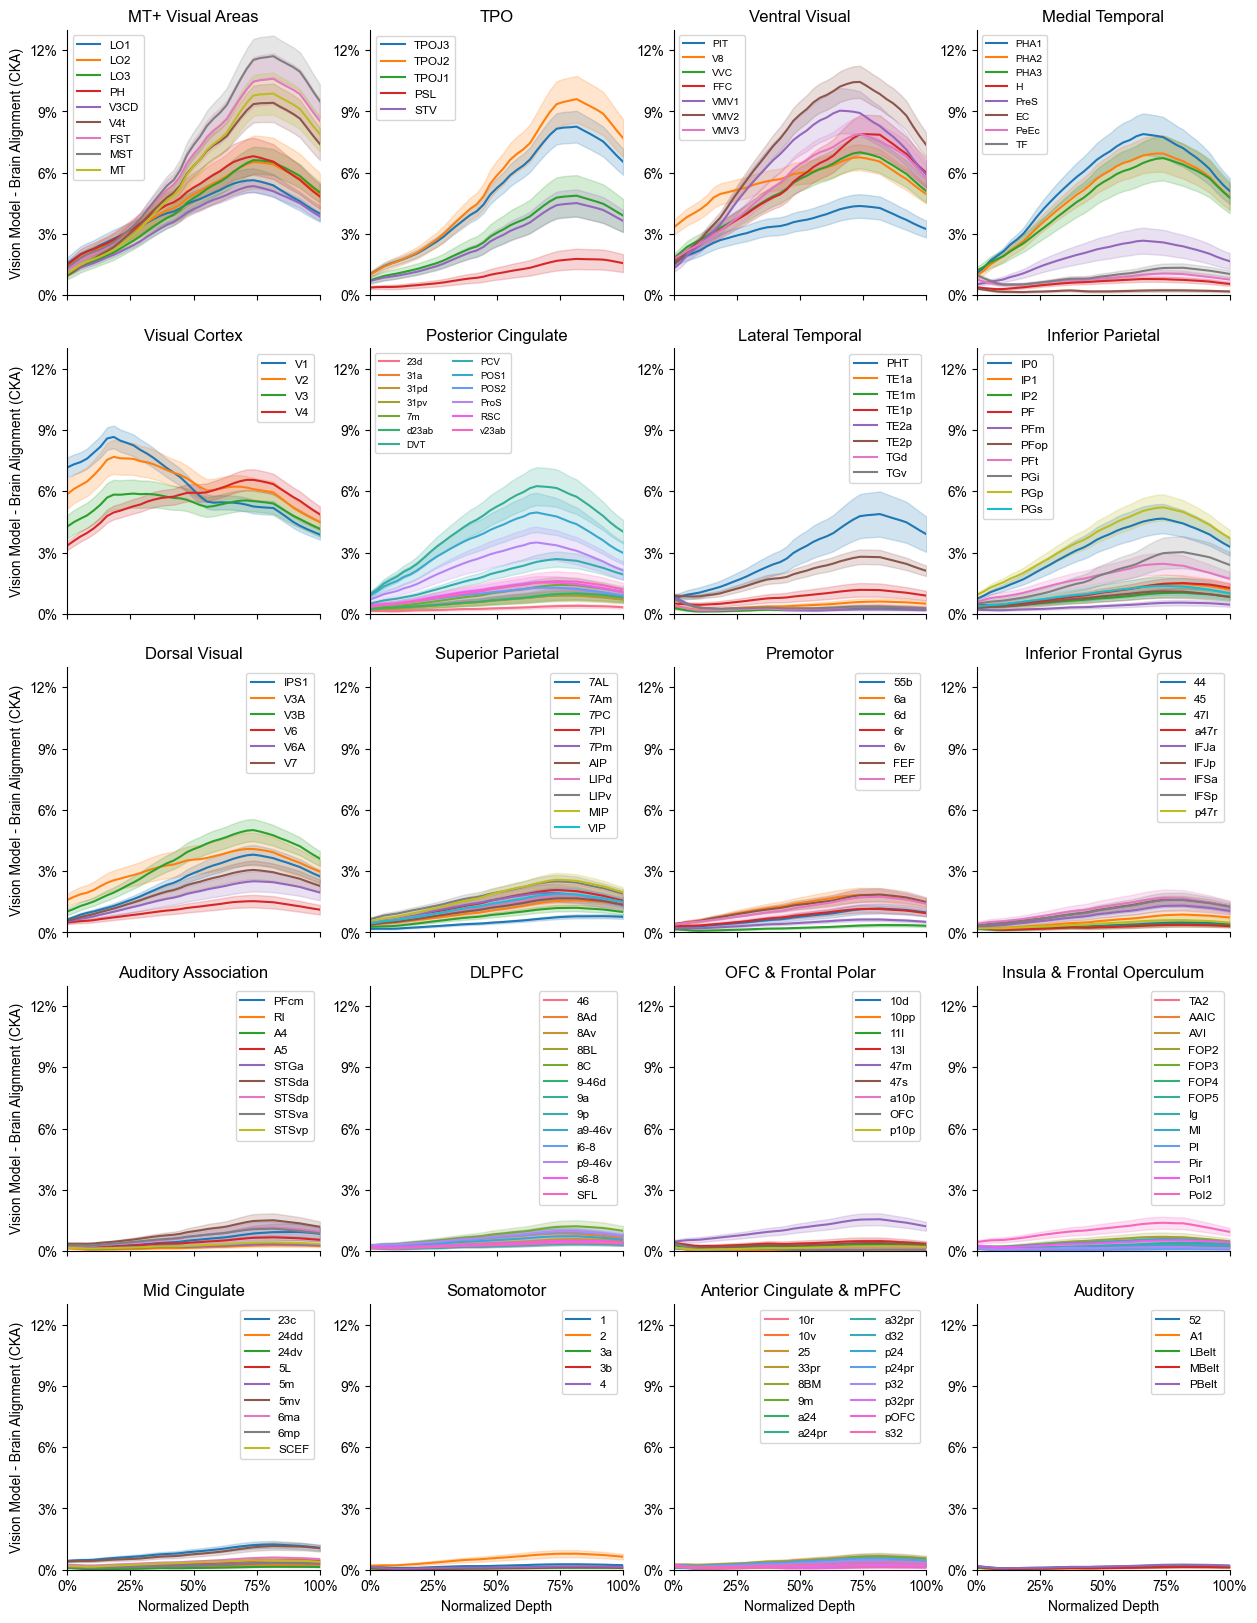

In [12]:
areas = df_vision.sort_values("score", ascending=False).drop_duplicates("area_id").area.tolist()

fig, axes = plt.subplots(5, 4, figsize=(15, 20), sharex=True)
axes = iter(axes.flatten())

custom = {"TPO": {'ncol': 1},
          "Lateral Temporal": {'ncol': 1, "fontsize": 8.2},
          "MT+ Visual Areas": {'ncol': 1, "fontsize": 8.2},
          "Ventral Visual": {'ncol': 1, "fontsize": 7.5},
          "Medial Temporal": {'ncol': 1, "fontsize": 7.5, "ylim": (0, 0.1)},
          "Posterior Cingulate": {'ncol': 2, "ylim": (0, 0.1), "fontsize": 7, "loc": "upper left"},
          "Anterior Cingulate & mPFC": {"ncol": 2}
          }

for i, area in enumerate(areas[:21]):
    if "Primary" in area: continue
    if "Early" in area:
        area = "Visual Cortex"
        names = ["V1", "V2", "V3", "V4"]
    else:
        df_vision_area = df_vision.query(f"area == '{area}'")
        names = df_vision_area.sort_values("roi_order").drop_duplicates("name").name.tolist()
    ax = next(axes)

    ncol = 1
    fontsize = 8.5
    ylim = None
    loc = "best"
    if area in custom:
        ncol = custom[area].get("ncol", ncol)
        fontsize = custom[area].get("fontsize", fontsize)    
        ylim = custom[area].get("ylim", None)
        loc = custom[area].get("loc", "best")
    
    plot_curves(df_vision, names, fig=fig, ax=ax, legend=True, add_areas=False, area_palette=False, loc=loc, ncol=ncol, fontsize=fontsize)
    ax.set_title(area)
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim(0, None)
    if i > 12:
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 1))
        #ax.yaxis.set_major_locator(mticker.MultipleLocator(0.005))
    elif i > 8:
        # Each 0.01
        ax.yaxis.set_major_locator(mticker.MultipleLocator(0.01))
    elif i>6:
        ax.yaxis.set_major_locator(mticker.MultipleLocator(0.02))
    
    if i in [0, 4, 9, 13, 17]:
        ax.set_ylabel("Vision Model - Brain Alignment (CKA)")
    ax.set_ylim(0, 0.13)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.03))
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

fig.savefig(folder / "model_curves_vision_all_regions.svg", bbox_inches='tight')
fig.savefig(folder / "model_curves_vision_all_regions.pdf", bbox_inches='tight')

### Subfig: Max layer

In [15]:
folder = output_folder / "peak_layers_brain"
folder.mkdir(exist_ok=True)

df = load_peak_layers(filename_model_separated, group_subjects=True)

for d, name in [(df.query("score>0.03"), "peak_layers_vision_003"), (df, "peak_layers_vision_all")]:
    save_brain_views(
        df=d,
        name=str(folder / name),
        hemispheres=["lh", "rh"],
        views=["lateral", "medial", "caudal", "ventral"],
        size=(2*800, 2*600),
        adjust=False,
        formats=["png", "tiff"],
        normalize=(0.2, 0.8),
        value_column="depth",
        default_color="gray",
        default_value=None,
        cmap="coolwarm",
    )

In [ ]:
folder = output_folder / "peak_layers_brain"
fig, ax = plot_cbar(cmap="coolwarm", title="Normalized Depth", vmin=0.2, vmax=0.8, locator=0.2, horizontal=True, rotation=0, labelpad=0, figsize = (6, 0.25))
fig.savefig(folder / "colorbar_02_08_coolwarm.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder / "colorbar_02_08_coolwarm.pdf", bbox_inches="tight", dpi=300, transparent=True)
#plt.close()

fig, ax = plot_cbar(cmap="coolwarm", title="Normalized Depth", vmin=0.2, vmax=0.8, locator=0.2, horizontal=False, rotation=90, labelpad=10, figsize = (0.25, 4))
fig.savefig(folder / "colorbar_02_08_coolwarm_vertical.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(folder / "colorbar_02_08_coolwarm_vertical.pdf", bbox_inches="tight", dpi=300, transparent=True)
#plt.close()

In [8]:
def add_pvalue_bracket(ax, x1, x2, y, height, color=(0.24, 0.24, 0.24), linewidth=1, text=None, y_text=None, **kwargs):
    """
    Draws a bracket (like those used to denote p-values) on a given axis.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis on which to plot the bracket.
    x1, x2 : float
        The x-coordinates between which the bracket is drawn.
    y : float
        The y-coordinate at which the bracket starts.
    height : float
        The vertical distance (height) of the bracket.
    color : str, optional
        The color of the lines.
    linewidth : float, optional
        The width of the lines.
    """
    # Draw the bracket:
    #   Vertical line up from (x1, y) to (x1, y+height)
    #   Horizontal line from (x1, y+height) to (x2, y+height)
    #   Vertical line down from (x2, y+height) to (x2, y)
    ax.plot([x1, x1, x2, x2],
            [y, y + height, y + height, y],
            color=color, linewidth=linewidth)
    if text:
        if not y_text:
            y_text = y + height
        ax.text((x1 + x2) * .5, y_text, text, ha='center', **kwargs)
    


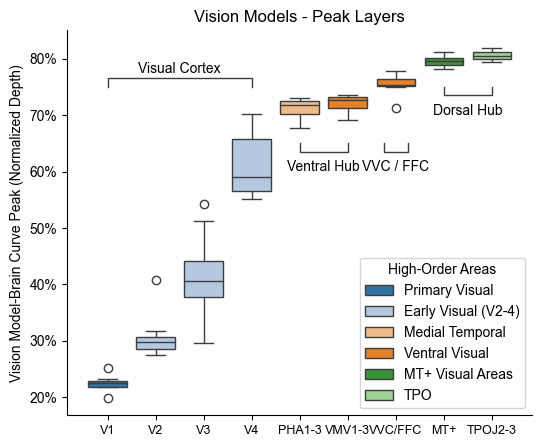

In [9]:
df = load_peak_layers(filename_model_separated, group_subjects=False)
clusters = {

    "V1": ["V1"],
    "V2": ["V2"],
    "V3": ["V3"],
    "V4": ["V4"],
    #"V8": ["V8"],
    "PHA1-3": ["PHA1", "PHA2", "PHA3"],
    
    "VMV1-3": ["VMV1", "VMV2", "VMV3"],
    "VVC/FFC": ["VVC", "FFC"],
    #"FFC": ["FFC"],
    "MT+": ["MT", "MST", "FST", "V4t"],
    "TPOJ2-3": ["TPOJ2", "TPOJ3"],
}
hcp = pd.read_csv(filename_hcp)



df["cluster"] = "Other"
for cluster, areas in clusters.items():
    df.loc[df.name.isin(areas), "cluster"] = cluster

# Supercluster
    # "Dorsal Hub": ["MT", "MST", "V4t", "FST", "TPOJ2", "TPOJ3"],
    # "Ventral Hub": ["PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    # "Visual Cortex": ["V1", "V2", "V3", "V4"],
    # "Intermediate": ["FFC", "VVC"],

supercluster = {
    "Visual Cortex": ["V1", "V2", "V3", "V4"],
    "Ventral Hub": ["PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    "Intermediate": ["FFC", "VVC"],
    "Dorsal Hub": ["MT", "MST", "V4t", "FST", "TPOJ2", "TPOJ3"],
}



df["supercluster"] = "Other"
for cluster, areas in supercluster.items():
    df.loc[df.name.isin(areas), "supercluster"] = cluster




fig, ax = plt.subplots(1, 1, figsize=(6, 5))
df_g = df.query("cluster != 'Other'").groupby(["subject", "cluster", "supercluster", "area", "area_color", "area_id"]).aggregate({"depth": "mean", "score": "mean"}).reset_index()

hue_order = df_g.drop_duplicates("area").sort_values("area_id").area.tolist()
palette = df_g.drop_duplicates("area").sort_values("area_id").area_color.tolist()

sns.boxplot(data=df_g, x="cluster", y="depth" , order=clusters.keys(), ax=ax, hue="area", palette=palette, hue_order=hue_order)
sns.despine(ax=ax)

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[3], handles[2], handles[4], handles[5]]
labels = [labels[0], labels[1], labels[3], labels[2], labels[4], labels[5]]
ax.legend(handles, labels, loc='lower right', ncol=1, title="High-Order Areas")

# Set legend title
#ax.legend(title="High-Order Areas", ncol=1, loc="lower right")
# Set xticks
ax.set_xticks(range(len(clusters)))

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=9)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax.set_ylabel("Vision Model-Brain Curve Peak (Normalized Depth)")
ax.set_title("Vision Models - Peak Layers")



add_pvalue_bracket(ax, x1=0, x2=3, y=0.75, height=0.015, text="Visual Cortex",  y_text=0.77, va='bottom')
add_pvalue_bracket(ax, x1=4, x2=5, y=0.65, height=-0.015, text="Ventral Hub",  y_text=0.62, va='top')
add_pvalue_bracket(ax, x1=5.75, x2=6.25, y=0.65, height=-0.015, text="VVC / FFC",  y_text=0.62, va='top')
add_pvalue_bracket(ax, x1=7, x2=8, y=0.75, height=-0.015, text="Dorsal Hub",  y_text=0.72, va='top')
folder = output_folder / "peak_layers_boxplots"
folder.mkdir(exist_ok=True)

fig.savefig(folder / "peak_layers_vision_clusters.svg", bbox_inches='tight', transparent=True)
fig.savefig(folder / "peak_layers_vision_clusters.pdf", bbox_inches='tight', transparent=True)


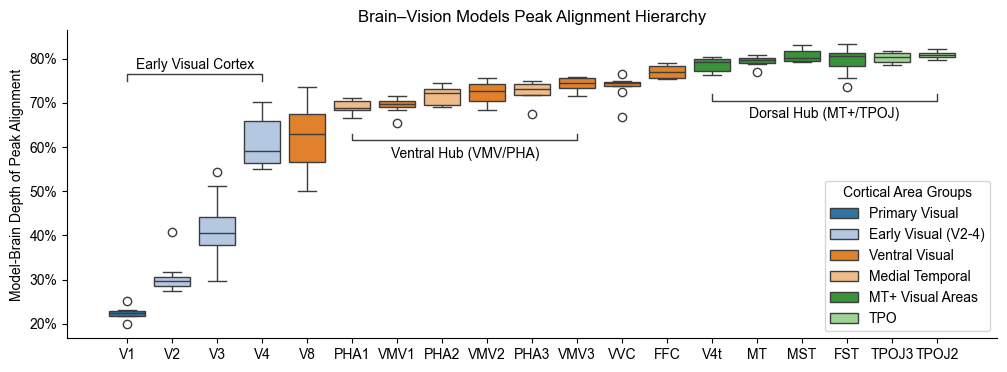

In [16]:
#df = load_peak_layers(filename_model_separated, group_subjects=False)
clusters = {

    "V1": ["V1"],
    "V2": ["V2"],
    "V3": ["V3"],
    "V4": ["V4"],
    "V8": ["V8"],
    #"PHA1-3": ["PHA1", "PHA2", "PHA3"],
    #"VMV1-3": ["VMV1", "VMV2", "VMV3"],
    "PHA1": ["PHA1"],
    "VMV1": ["VMV1"],
    "PHA2": ["PHA2"],
    "VMV2": ["VMV2"],
    "PHA3": ["PHA3"],
    #"V3B": ["V3B"],
    "VMV3": ["VMV3"],
    "VVC": ["VVC"],
    "FFC": ["FFC"],
    #"MT+": ["MT", "MST", "FST", "V4t"],
    # "TPOJ2-3": ["TPOJ2", "TPOJ3"],
    "V4t": ["V4t"],
    "MT": ["MT"],
    "MST": ["MST"],
    "FST": ["FST"],
    "TPOJ3": ["TPOJ3"],
    "TPOJ2": ["TPOJ2"],
}
hcp = pd.read_csv(filename_hcp)



df["cluster"] = "Other"
for cluster, areas in clusters.items():
    df.loc[df.name.isin(areas), "cluster"] = cluster

# Supercluster
    # "Dorsal Hub": ["MT", "MST", "V4t", "FST", "TPOJ2", "TPOJ3"],
    # "Ventral Hub": ["PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    # "Visual Cortex": ["V1", "V2", "V3", "V4"],
    # "Intermediate": ["FFC", "VVC"],

supercluster = {
    "Visual Cortex": ["V1", "V2", "V3", "V4"],
    "Ventral Hub": ["PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    "Intermediate": ["FFC", "VVC"],
    "Dorsal Hub": ["V4t", "MT", "MST",  "FST",  "TPOJ3", "TPOJ2"],
}



df["supercluster"] = "Other"
for cluster, areas in supercluster.items():
    df.loc[df.name.isin(areas), "supercluster"] = cluster




fig, ax = plt.subplots(1, 1, figsize=(12, 4))
df_g = df.query("cluster != 'Other'").groupby(["subject", "cluster", "supercluster", "area", "area_color", "area_id"]).aggregate({"depth": "mean", "score": "mean"}).reset_index()

hue_order = df_g.drop_duplicates("area").sort_values("area_id").area.tolist()
palette = df_g.drop_duplicates("area").sort_values("area_id").area_color.tolist()

sns.boxplot(data=df_g, x="cluster", y="depth" , order=clusters.keys(), ax=ax, hue="area", palette=palette, hue_order=hue_order)
sns.despine(ax=ax)

# Set legend title
ax.legend(title="Cortical Area Groups", ncol=1, loc="lower right")
# Set xticks
ax.set_xticks(range(len(clusters)))

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax.set_ylabel("Model-Brain Depth of Peak Alignment")

order = {k:i  for i, k in enumerate(clusters.keys())}
df_g["order"] = df_g.cluster.map(order)

#c = "#181818"
#sns.lineplot(data=df_g, x="order", y="depth", hue='subject', palette=len(order)*[c], ax=ax, legend=False, zorder=-10, linewidth=0.5)

add_pvalue_bracket(ax, x1=0, x2=3, y=0.75, height=0.015, text="Early Visual Cortex",  y_text=0.77, va='bottom')
a = 1
b = 1
add_pvalue_bracket(ax, x1=4+a, x2=9+b, y=0.63, height=-0.015, text="Ventral Hub (VMV/PHA)",  y_text=0.6, va='top')
#add_pvalue_bracket(ax, x1=10, x2=11, y=0.65, height=-0.015, text="VVC / FFC",  y_text=0.62, va='top')
a = 1
add_pvalue_bracket(ax, x1=12+a, x2=17+a, y=0.72, height=-0.015, text="Dorsal Hub (MT+/TPOJ)",  y_text=0.69, va='top')

ax.set_title("Brain–Vision Models Peak Alignment Hierarchy")
fig.savefig(folder / "peak_layers_vision_rois_19.svg", bbox_inches='tight', transparent=True)
fig.savefig(folder / "peak_layers_vision_rois_19.pdf", bbox_inches='tight', transparent=True)

In [12]:
folder

PosixPath('figure_alignment_hierarchy/peak_layers_boxplots')

In [31]:
df_g.groupby("cluster").depth.median().reset_index().sort_values("depth")

,cluster,depth
9,V1,0.224617
10,V2,0.297913
11,V3,0.405699
13,V4,0.590217
15,V8,0.628635
4,PHA1,0.689042
16,VMV1,0.696920
5,PHA2,0.722962
17,VMV2,0.726651
6,PHA3,0.732089


### Subfig comparisons alignment vs peak layer

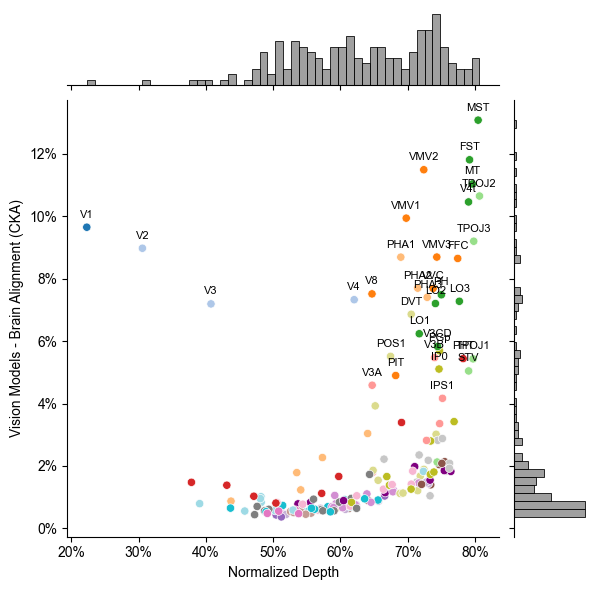

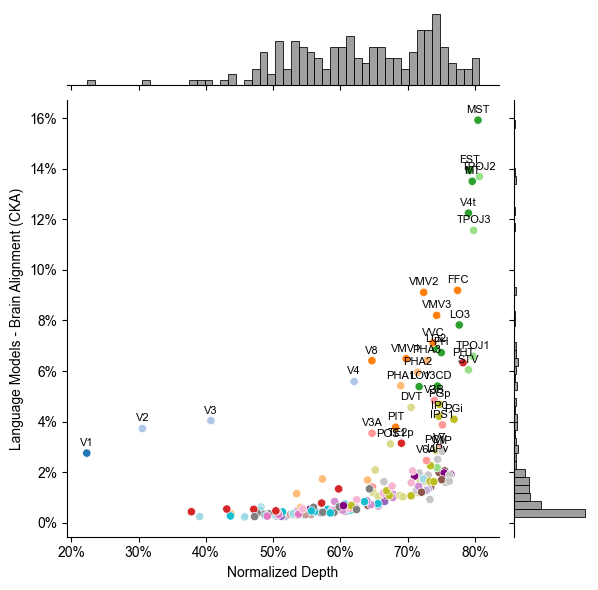

In [12]:
folder = output_folder / "peak_layers_comparison"
folder.mkdir(exist_ok=True)

df_lang = load_peak_layers(filename_model_joined, group_subjects=True, modality="language")
df_vision = load_peak_layers(filename_model_joined, group_subjects=True, modality="vision")
df_lang = df_lang[['roi', 'score', 'depth']].rename(columns={'score': 'score_lang', 'depth': 'depth_lang'})
df_mix = df_vision.merge(df_lang, on='roi')


g = plot_comparison(df_mix, x='depth', y='score', threshold_x=None, threshold_y=0.04)
g.set_axis_labels("Normalized Depth", "Vision Models - Brain Alignment (CKA)")
g.savefig(folder / "peak_layers_vision_comparison.svg", bbox_inches='tight')


g = plot_comparison(df_mix, x='depth', y='score_lang', threshold_x=None, threshold_y=0.024)
g.set_axis_labels("Normalized Depth", "Language Models - Brain Alignment (CKA)")
g.savefig(folder / "peak_layers_language_comparison.svg", bbox_inches='tight')

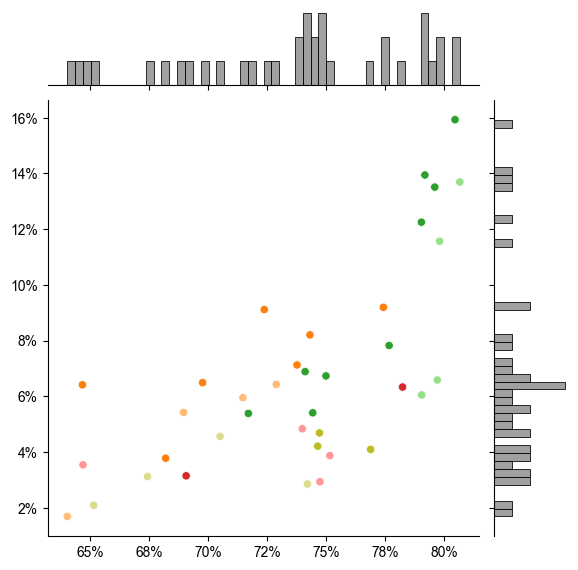

In [46]:

query = "(score > 0.03 or score_lang > 0.03) and area_id > 1"
#query = "score > 0.03 or score_lang > 0.03"

g = plot_comparison(df_mix.query(query), x='depth', y='score_lang', threshold_x=None, threshold_y=1)

# Make a line plot regression
#sns.regplot(data=df_mix.query("score > 0.03 and depth > 0.5"), x='depth', y='score_lang', scatter=False, line_kws={'color': 'black'}, ax=g.ax_joint)

# Set xscale to log



### Subfig: Max layer boxplot

In [ ]:
folder = output_folder / "peak_layers_vision_boxplot"
folder.mkdir(exist_ok=True)
df_vision = load_peak_layers(filename_model_joined, group_subjects=False, modality="vision")

for version in ("all", "top"):
    df_sorted = df_vision.groupby(["name", "area", "area_color", "area_id", "roi_order"]).aggregate({"depth": "mean", "score": "mean"}).sort_values("depth", ascending=True).reset_index()
    if version == "top":
        df_sorted = df_sorted.query("score > 0.03")
    names = df_sorted.name.tolist()
    df_sorted = df_sorted.sort_values(["area_id", "roi_order"])
    areas = df_sorted.area.tolist()
    palette = df_sorted.area_color.tolist()


    if version == 'all':
        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    sns.boxplot(df_vision, x='name', y='depth', ax=ax, order=names, hue='area', hue_order=areas, palette=palette, legend=True)
    ax.legend(loc='lower right', ncol=4, title="", fontsize=8)
    sns.despine(ax=ax)
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7);
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.set_ylabel("Vision Models Max Alignment (Normalized Depth)")
    ax.set_xlabel("")

    for i in np.arange(0.2, 0.8, 0.2):
        ax.axhline(i, ls='--', lw=0.5, color='gray', zorder=-10)
    
    fig.savefig(folder / f"peak_layers_vision_{version}.pdf", bbox_inches='tight')

### Untrained vision curves

In [1]:
df = pd.read_parquet(filename_untrained_vision)
df['excluded'] = False
df_vision = read_models_interpolated(df, modality='vision')
#df_vision


fig, (ax, ax1) = plt.subplots(1, 2, figsize=(7, 5))
#fig, ax = plt.subplots(1, 1, figsize=(3.5, 5))

names = ["V1", "V2", "V3B", "MST", "VMV2", "PHA2", "TPOJ2",  "DVT"]
ylim = (0, 0.052)
plot_curves(df_vision, names, fig=fig, ax=ax, legend=False, fontsize=9, loc='best', ylim=ylim)
ax.set_ylabel("Untrained Model-Brain Alignment (CKA)")
ax.set_title("Untrained Vision Models")
folder = output_folder / "untrained_model_curves"
folder.mkdir(exist_ok=True)
#fig.savefig(folder / "untrained_model_curves_vision.svg", bbox_inches='tight')
#fig.savefig(folder / "untrained_model_curves_vision.pdf", bbox_inches='tight')

ax = ax1

df = pd.read_parquet(filename_untrained_language)
df['excluded'] = False
df_lang = read_models_interpolated(df, modality='language')
df_lang




names = ["V1", "V2", "V3B", "MST", "VMV2", "PHA2", "TPOJ2",  "DVT"]
ylim = (0, 0.052)
plot_curves(df_lang, names, fig=fig, ax=ax, legend=False, fontsize=9, loc='best', ylim=ylim)
#ax.set_ylabel("Untrained Model-Brain Alignment (CKA)")
ax.set_ylabel("")
ax.set_title("Untrained Language Models")
folder = output_folder / "untrained_model_curves"
folder.mkdir(exist_ok=True)
fig.savefig(folder / "untrained_model_curves.svg", bbox_inches='tight', transparent=True)
fig.savefig(folder / "untrained_model_curves.pdf", bbox_inches='tight', transparent=True)


NameError: name 'pd' is not defined

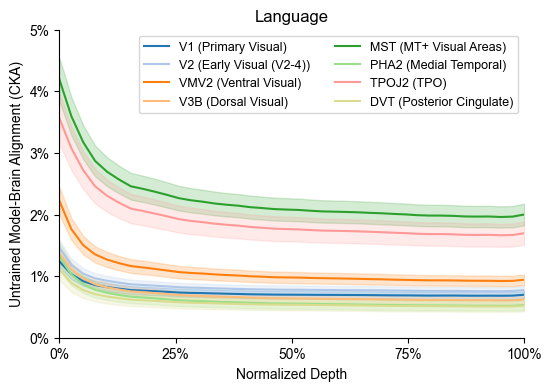

In [8]:
df = pd.read_parquet(filename_untrained_language)
df['excluded'] = False
df_lang = read_models_interpolated(df, modality='language')
df_lang


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

names = ["V1", "V2", "V3B", "MST", "VMV2", "PHA2", "TPOJ2",  "DVT"]
ylim = (0, 0.05)
plot_curves(df_lang, names, fig=fig, ax=ax, legend=True, fontsize=9, loc='best', ylim=ylim)
ax.set_ylabel("Untrained Model-Brain Alignment (CKA)")
ax.set_title("Language")
folder = output_folder / "untrained_model_curves"
folder.mkdir(exist_ok=True)
fig.savefig(folder / "untrained_model_curves_language.svg", bbox_inches='tight')
fig.savefig(folder / "untrained_model_curves_language.pdf", bbox_inches='tight')


## Tokenizers

In [ ]:
df_tokenizer = pd.read_parquet(filename_tokenizer)
hcp = pd.read_csv(filename_hcp)
hcp = hcp[["name", "roi", "roi_order", "area_id", "area", "area_color", "mne_name"]]
df_tokenizer = df_tokenizer.groupby(["tokenizer", "roi", "subject"]).aggregate({"score": "mean"}).reset_index()
df_tokenizer = df_tokenizer.groupby(["tokenizer", "roi"]).aggregate({"score": "mean"}).reset_index()
df_tokenizer_models = df_tokenizer.query("tokenizer in ['openlm-research/open_llama_3b', 'meta-llama/Meta-Llama-3-8B', 'meta-llama/Llama-2-7b']")
df_tokenizer_models = df_tokenizer_models.groupby(["roi"]).aggregate({"score": "mean"}).reset_index()
df_tokenizer_models = df_tokenizer_models.merge(hcp, on="roi")
df_language_first = read_models_interpolated(filename_model_joined, modality='language')
df_language_first = df_language_first[df_language_first.layer == 0]
df_language_first = df_language_first.groupby(["roi"]).score.mean().reset_index().rename(columns={"score": "score_first_layer"})
df_tokenizer_models = df_tokenizer_models.merge(df_language_first, on="roi")

g = plot_comparison(df_tokenizer_models, x='score_first_layer', y='score', threshold_x=0.035, threshold_y=0.03, default_shift_y=0.0013)
g.set_axis_labels("Language Model First Layer - Brain Alignment (CKA)", "Tokenizer - Brain Alignment (CKA)")

folder = output_folder / "tokenizer_comparison"
folder.mkdir(exist_ok=True)
g.savefig(folder / "tokenizer_comparison.svg", bbox_inches='tight')

### Subfig: Curves by model family

In [ ]:
df_vision = read_models_interpolated(filename_model_joined, modality='vision', aggregate_models=False)

family = {k : v['family'] for k, v in model_info.items()}
size = {k : v['size'] for k, v in model_info.items()}
    
modality = "vision"

df_vision['family'] = df_vision.model.replace(family)
df_vision['model_size'] = df_vision.model.replace(size)
df_vision
df_vision_families = df_vision.groupby(["family", "subject", "roi"]).aggregate({"scores": "mean"}).reset_index()
df_vision_families = df_vision_families.rename(columns={'family': 'model'})
df_vision_families['modality'] = modality
df_vision_families = unpack_scores(df_vision_families)
hcp = pd.read_csv(filename_hcp)
hcp = hcp[["name", "roi", "roi_order", "area_id", "area", "area_color"]]
df_vision_families = df_vision_families.merge(hcp, on="roi")
df_vision_families

names = ["V1", "V2", "V3B", "MST", "VMV2", "PHA2", "TPOJ2",  "DVT"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=False, gridspec_kw={'wspace': 0.1, 'hspace': 0.15})
axes = axes.flatten()
axes_iter = iter(axes)
for ax, family in zip(axes_iter, df_vision_families.model.unique()):
    df_family = df_vision_families.query(f"model == '{family}' and name in @names")
    ylim = (0, 0.158)
    legend = True if family == "ViT CLIP-ft" else False
    plot_curves(df_family, names, fig=fig, ax=ax, legend=legend, fontsize=10, loc='center left', ylim=ylim, ncol=1)
    # Locatte of the title inside the plot centered
    ax.set_title(f"{family}", pad=-10)
    ax.set_ylabel("Models - Brain Alignment (CKA)")

axes[-1].axis('off')

# Move legend of axes[-2] to the right
axes[-2].legend(loc='center right', title="", ncol=1, fontsize=10, bbox_to_anchor=(1.9, 0.5))

folder = output_folder / "model_curves_family"
axes[-1].axis('off')
folder.mkdir(exist_ok=True)
#axes[0].set_xticklabels([])
#axes[1].set_xticklabels([])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.savefig(folder / "model_curves_vision_family.svg", bbox_inches='tight')
fig.savefig(folder / "model_curves_vision_family.pdf", bbox_inches='tight')



In [ ]:
df_language = read_models_interpolated(filename_model_joined, modality='language', aggregate_models=False)

family = {k : v['family'] for k, v in model_info.items()}
size = {k : v['size'] for k, v in model_info.items()}
    
modality = "language"

df_language['family'] = df_language.model.replace(family)
df_language['model_size'] = df_language.model.replace(size)

df_lang_families = df_language.groupby(["family", "subject", "roi"]).aggregate({"scores": "mean"}).reset_index()
df_lang_families = df_lang_families.rename(columns={'family': 'model'})
df_lang_families['modality'] = modality
df_lang_families = unpack_scores(df_lang_families)
hcp = pd.read_csv(filename_hcp)
hcp = hcp[["name", "roi", "roi_order", "area_id", "area", "area_color"]]
df_lang_families = df_lang_families.merge(hcp, on="roi")


names = ["V1", "V2", "V3B", "MST", "VMV2", "PHA2", "TPOJ2",  "DVT"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=False, gridspec_kw={'wspace': 0.1, 'hspace': 0.15})
axes = axes.flatten()
axes_iter = iter(axes)
for ax, family in zip(axes_iter, df_lang_families.model.unique()):
    df_family = df_lang_families.query(f"model == '{family}' and name in @names")
    ylim = (0, 0.178)
    legend = True if 'Open' in family else False
    plot_curves(df_family, names, fig=fig, ax=ax, legend=legend, fontsize=10, loc='center left', ylim=ylim, ncol=1)
    # Locatte of the title inside the plot centered
    ax.set_title(f"{family}", pad=-10)
    ax.set_ylabel("Models - Brain Alignment (CKA)")

axes[-1].axis('off')
axes[-2].axis('off')

# Move legend of axes[-2] to the right
axes[-3].legend(loc='center right', title="", ncol=1, fontsize=10, bbox_to_anchor=(1.9, 0.5))

folder = output_folder / "model_curves_family"
#axes[-1].axis('off')
folder.mkdir(exist_ok=True)

axes[0].set_xlabel("")
fig.savefig(folder / "model_curves_language_family.svg", bbox_inches='tight')
fig.savefig(folder / "model_curves_language_family.pdf", bbox_inches='tight')

### Subfig: Alignment curve miniature

In [ ]:
df_vision = read_models_interpolated(filename_model_joined, modality='vision')
df_vision['depth'] = df_vision.layer / df_vision.layer.max()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1.3, 1))

df_roi = df_vision.query("roi==2")
color = df_roi.area_color.unique()[0]
sns.lineplot(df_roi, x='depth', y='score', hue='name', legend=False, ax=ax, errorbar='se', palette=[color])

ax.set_xlabel("")
ax.set_ylabel("")
sns.despine(ax=ax)
ax.set_xlim(0, 1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
folder = output_folder / "model_curve_miniature"
folder.mkdir(exist_ok=True)
fig.savefig(folder / "model_curve_miniature.svg", bbox_inches='tight', transparent=True)
fig.savefig(folder / "model_curve_miniature.pdf", bbox_inches='tight', transparent=True)


## Model alignment - Partitions

In [45]:
df_models = pd.read_parquet(filename_partitions)
df_models["modality"] = df_models.model_name.apply(lambda x: 'language' if str(x).endswith("-coco") else 'vision')
df_models = df_models.query("score < 1 and score > -0.5")
df_models = df_models.groupby(["modality", "metric", "subject", "roi", "partition", "model_name"]).aggregate({"score": "max", "n_images": "mean"}).reset_index()
df_models = df_models.groupby(["modality", "metric", "subject", "roi", "partition"]).aggregate({"score": "mean", "n_images": "mean"}).reset_index()
df_models = df_models.groupby(["modality", "metric", "roi", "partition"]).aggregate({"score": "mean", "n_images": "mean"}).reset_index()
hcp = pd.read_csv(filename_hcp)
hcp = hcp[["name", "mne_name", "roi", "roi_order", "area_id", "area", "area_color"]]
df_models = df_models.merge(hcp, on="roi")
df_models

,modality,metric,roi,partition,score,n_images,name,mne_name,roi_order,area_id,area,area_color
0,language,unbiased_cka,1,all,0.030818,2639.75,V1,L_V1_ROI-lh,0,0,Primary Visual,#1f77b4
1,language,unbiased_cka,1,food static,0.059514,187.75,V1,L_V1_ROI-lh,0,0,Primary Visual,#1f77b4
2,language,unbiased_cka,1,motion,0.039953,642.75,V1,L_V1_ROI-lh,0,0,Primary Visual,#1f77b4
3,language,unbiased_cka,1,motion animal,0.153754,38.00,V1,L_V1_ROI-lh,0,0,Primary Visual,#1f77b4
4,language,unbiased_cka,1,non-person,0.030297,1492.50,V1,L_V1_ROI-lh,0,0,Primary Visual,#1f77b4
...,...,...,...,...,...,...,...,...,...,...,...,...
9355,vision,unbiased_cka,360,person motion,0.005542,536.25,p24,R_p24_ROI-rh,143,18,Anterior Cingulate & mPFC,#17becf
9356,vision,unbiased_cka,360,person static,0.009556,611.00,p24,R_p24_ROI-rh,143,18,Anterior Cingulate & mPFC,#17becf
9357,vision,unbiased_cka,360,sports,0.008852,528.25,p24,R_p24_ROI-rh,143,18,Anterior Cingulate & mPFC,#17becf
9358,vision,unbiased_cka,360,static,0.007816,1997.00,p24,R_p24_ROI-rh,143,18,Anterior Cingulate & mPFC,#17becf


In [56]:
df_models.query("partition == @partition['partition'] and modality==@modality")

ValueError: data type must provide an itemsize

In [ ]:
partitions = df_models[["partition", 'n_images']].drop_duplicates().sort_values("n_images",  ascending=False).to_dict(orient='records')
modalities = df_models.modality.unique()
normalize=(0, 0.2)
folder = output_folder / "model_brain_partitions"
folder.mkdir(exist_ok=True)
hemispheres = ["rh"]
views = ["lateral", "ventral", "medial"]

pbar = tqdm(total=len(partitions)*len(modalities)*len(hemispheres)*len(views))

for hemisphere in hemispheres:
    for partition in partitions:
        num_images = int(partition['n_images'])
        partition = partition['partition']
        for modality in modalities:    
            brain = plot_faverage_parcelation(df_models.query("partition == @partition and modality==@modality"), normalize=normalize, hemisphere=hemisphere)
            for view in views: 
                pbar.set_description(f"{partition} {modality} {hemisphere} {view}")
                brain.show_view(view)
                brain.save_image(folder / f"model_brain_{partition}_{modality}_{hemisphere}_{num_images}_{view}_cka_0_20.png", mode="rgba")
                pbar.update(1)
            brain.close()
            


  0%|          | 0/78 [00:00<?, ?it/s]

Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1


In [ ]:
#images

# Sort by model_split


[PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_all_language_rh_2639_lateral_cka_0_20.png'),
 PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_all_language_rh_2639_ventral_cka_0_20.png'),
 PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_all_vision_rh_2639_lateral_cka_0_20.png'),
 PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_all_vision_rh_2639_ventral_cka_0_20.png'),
 PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_food static_language_rh_187_lateral_cka_0_20.png'),
 PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_food static_language_rh_187_ventral_cka_0_20.png'),
 PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_food static_vision_rh_187_lateral_cka_0_20.png'),
 PosixPath('figure_alignment_hierarchy/model_brain_partitions/model_brain_food static_vision_rh_187_ventral_cka_0_20.png'),
 PosixPath('figure_alignment

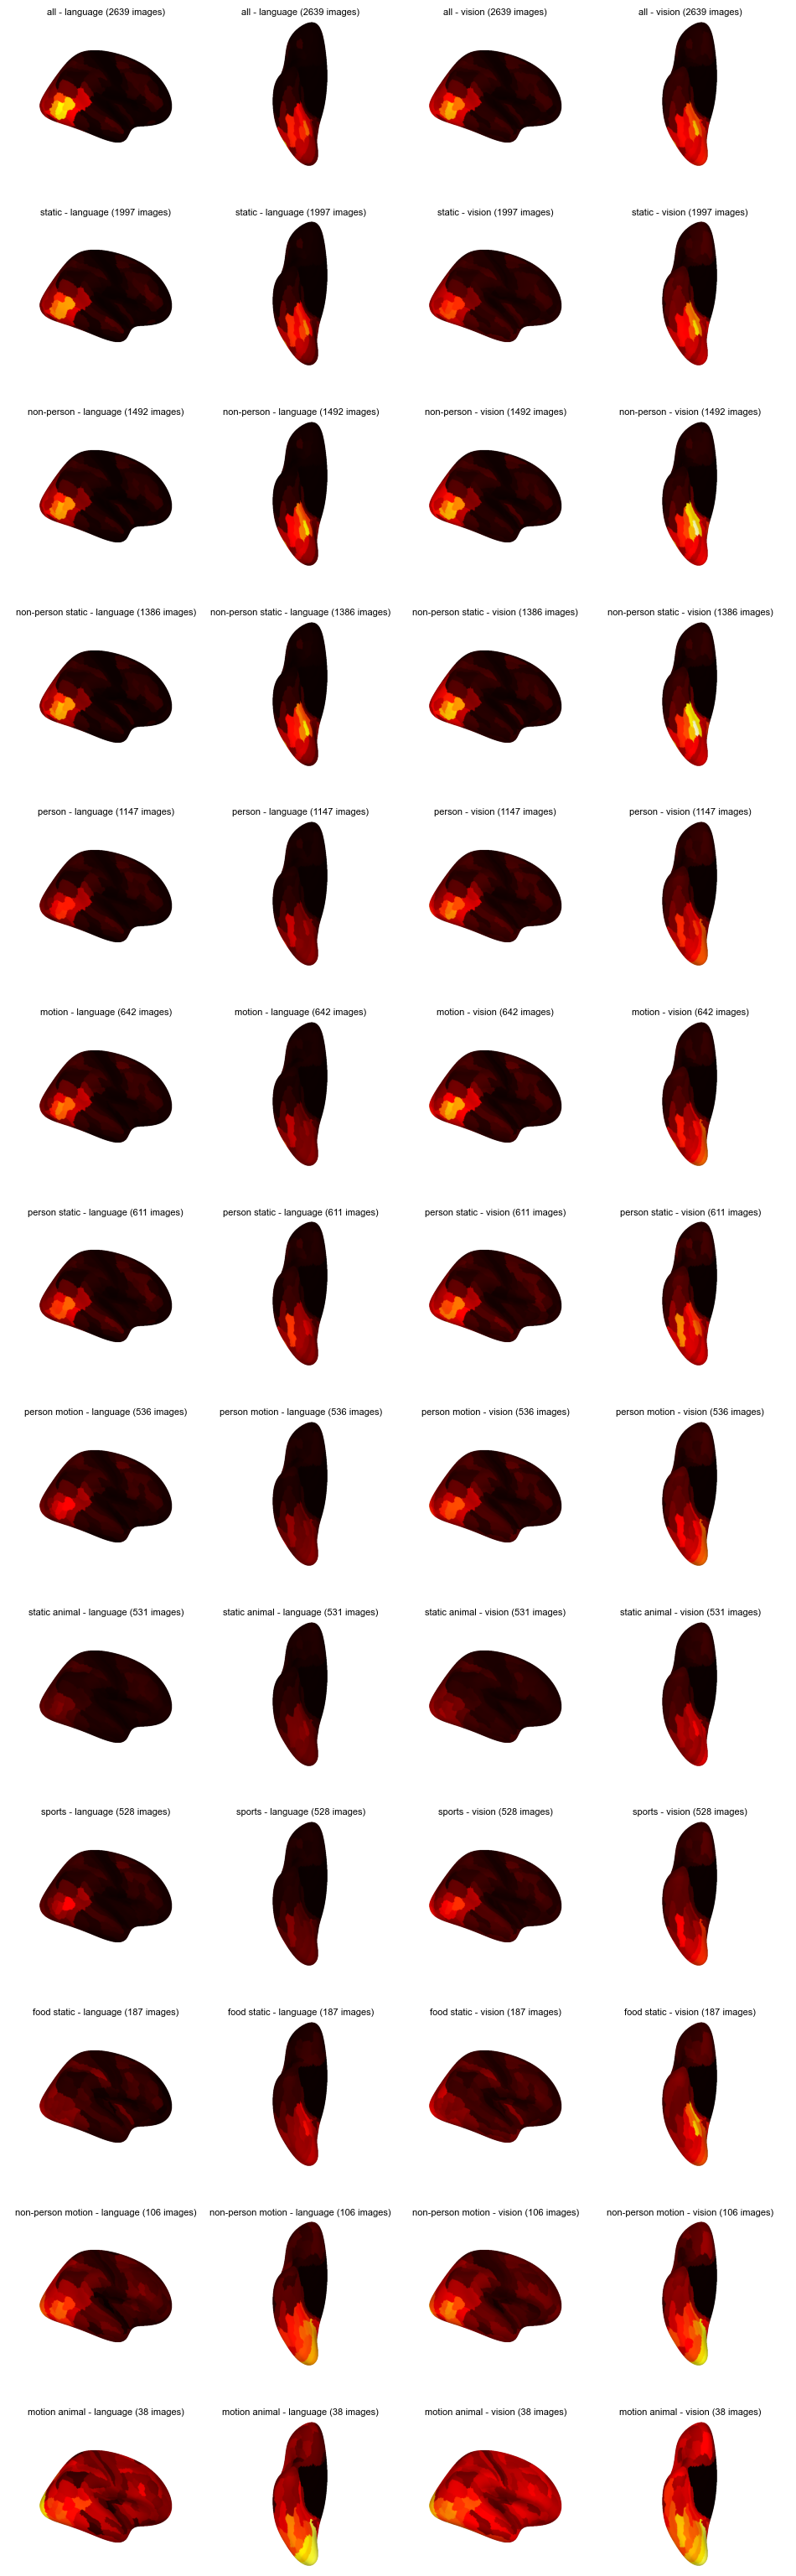

In [85]:
images = list(folder.glob("*.png"))
images.sort(key= lambda x: x.stem)
images.sort(key=lambda x: -int(x.stem.split("_")[5]))

# Remove those with medial in the name
images = [i for i in images if 'medial' not in i.name]


# # 4 columns x 13 rows
fig, axes = plt.subplots(13, 4, figsize=(12, 40), sharex=True, sharey=True, gridspec_kw={'wspace': 0.0, 'hspace': 0.1})
axes = axes.flatten()
for ax, image in zip(axes, images):
    img = Image.open(image)
    
    # Plot in the ax
    n_images = int(image.stem.split("_")[5])
    ax.imshow(img)
    ax.axis('off')
    stem = image.stem
    modality = stem.split("_")[3]
    partition = stem.split("_")[2]
    ax.set_title(f"{partition} - {modality} ({n_images} images)", fontsize=8)
fig.savefig(folder / "model_brain_partitions_all.pdf", bbox_inches='tight')